In [1]:
## Importing the packages
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams
from warnings import filterwarnings
from datetime import datetime
import os
filterwarnings("ignore")

#Iteration
import itertools

#ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

#for Text Mining
import re 
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import WordNetLemmatizer 
import nltk 
from nltk.corpus import inaugural
from nltk.draw.dispersion import dispersion_plot
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score,recall_score,precision_score

# Declaring this to show graphs after inline command instead of plt.show() after every instance of plotting
%matplotlib inline

#Set the max number of rows in output cell to 30
pd.options.display.max_rows = 30


#Ignore unnecessary warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
data_directory = "Documents Classification - Machine Learning\Text Docs"
# categories = ["business", "food","medical","space"]
categories = ["business", "food","medical","space","sport","entertainment","historical","graphics","politics"]  # Add or remove based on your categories

documents = []
labels = []

for category in categories:
    category_path = os.path.join(data_directory, category)
    for filename in os.listdir(category_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(category_path, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                content = file.read()
                documents.append(content)
                labels.append(category)

In [3]:
documents

['German bidder in talks with LSE\n\nDeutsche Boerse bosses have held "constructive, professional and friendly" talks with the London Stock Exchange (LSE), its chief has said.\n\nWerner Seifert met LSE chief executive Clara Furse amid rumours the German group may raise its bid to £1.5bn ($2.9bn) from its initial £1.3bn offer. However, rival suitor Euronext also upped the ante in the bid battle. Ahead of talks with the LSE on Friday, the pan-European bourse said it may be prepared to make its offer in cash. The Paris-based exchange, owner of Liffe in London, is reported to be ready to raise £1.4bn to fund a bid.\n\nThe news came as Deutsche Boerse held its third meeting with the LSE since its bid approach in December which was turned down by the London exchange for undervaluing the business. However, the LSE did agree to leave the door open for talks to find out whether a "significantly-improved proposal" would be in the interests of LSE\'s shareholders and customers. In the meantime, E

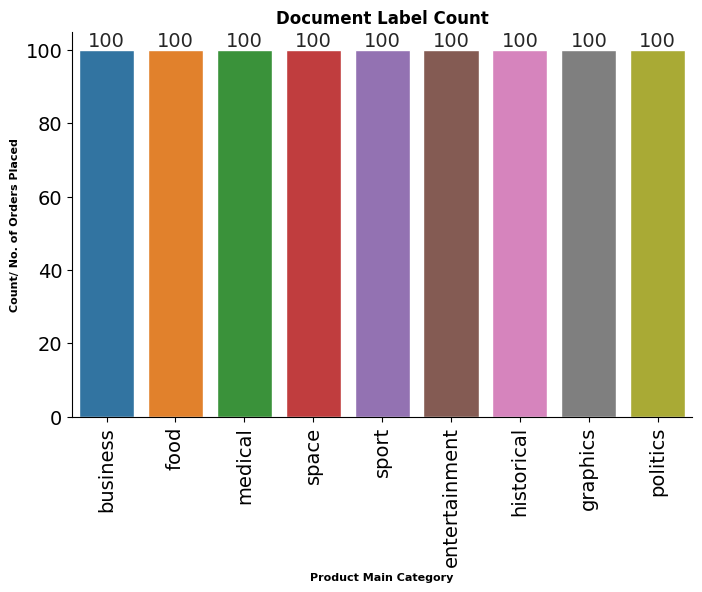

In [4]:
#Declare Figure and specify an appropriate size and title
plt.figure(figsize=(8,5))
plt.title("Document Label Count",fontsize=12, weight="bold")

#Remove outer border and set grid style 
sns.despine()
sns.set_style("whitegrid")

#Plot the graph using seabont countplot and specify where data values must appear
ax = sns.countplot(x=labels);
ax.bar_label(ax.containers[0],label_type="edge",fontsize= 14);

#Label the axes and rotate the label of the categories so that it is readable 
plt.xticks(rotation = 90)
plt.xlabel("Product Main Category",fontsize=8, weight="bold");
plt.ylabel("Count/ No. of Orders Placed",fontsize=8, weight="bold");
ax.tick_params(labelsize = 14)

In [5]:
# Text Preprocessing: Tokenize -> Clean -> Remove Stop words -> Lemmatize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(doc):
    #Tokenize the text first
    tokens = nltk.word_tokenize(doc)
    #Clean for special charecters and then convert enter text to lowercase
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return ' '.join(tokens)

In [6]:
processed_docs = [preprocess(doc) for doc in documents]
labels = [label for label in labels]

In [7]:
# Step 3: Feature Extraction/ Vectorization
# BoW
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(processed_docs)

# N-grams
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3)) # unigrams + bigrams +trigrams
X_ngram = ngram_vectorizer.fit_transform(processed_docs)

In [8]:
# Function to return best model and its performance given a model and its parameter grid
def best_model(clf, param_grid, X, Y):
    grid = GridSearchCV(clf, param_grid, scoring='accuracy',verbose=True,cv=10)
    grid.fit(X, Y)
    best_clf = grid.best_estimator_
    best_params = grid.best_params_
    return best_clf, best_params

# Specify parameter grid for each model
param_grids = {
    MultinomialNB(): {'alpha': [0.01, 0.1, 1.0]},
    LogisticRegression(): {'solver': ['newton-cg', 'sag', 'saga']},
    RandomForestClassifier(): {'n_estimators': [500,1000]},
    # DecisionTreeClassifier(): {'max_depth': [10, 15]},
    SVC(): {'kernel': ['linear', 'rbf']}}

In [9]:
# Update doc_clf_model to use best_model
def doc_clf_model(clf, param_grid, X, Y):
    best_clf, best_params = best_model(clf, param_grid, X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=23,stratify=Y)
    best_clf.fit(X_train, Y_train)
    accuracy = accuracy_score(Y_test, best_clf.predict(X_test))
    recall = recall_score(Y_test, best_clf.predict(X_test), average='macro')
    precision = precision_score(Y_test, best_clf.predict(X_test), average='macro')
    return best_clf, accuracy, recall, precision, best_params

In [10]:
#Intialise Dataframes
model_performance = pd.DataFrame(columns=["Model","Accuracy","Recall","Precision","Best Params"])
Doc_df = pd.DataFrame({'Document': documents,'Actual_Label': labels})
# Enhance the loop to use updated doc_clf_model
for model, param_grid in param_grids.items():
    clf, accuracy, recall, precision, best_params = doc_clf_model(model, param_grid, X_ngram, labels)
    temp_df = pd.DataFrame({"Model": clf.__class__.__name__,"Accuracy": accuracy,"Recall": recall,"Precision": precision,
                            "Best Params": best_params})
    model_performance = pd.concat([model_performance,temp_df], ignore_index=True)
    Doc_df[f'Predicted_Label_{model}'] = clf.predict(X_ngram)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [11]:
model_performance.round(3)

,Model,Accuracy,Recall,Precision,Best Params
0,MultinomialNB,0.959,0.959,0.964,1.0
1,LogisticRegression,0.985,0.985,0.985,sag
2,RandomForestClassifier,0.944,0.944,0.949,500
3,SVC,0.926,0.926,0.941,linear


In [12]:
Doc_df.head()

,Document,Actual_Label,Predicted_Label_MultinomialNB(),Predicted_Label_LogisticRegression(),Predicted_Label_RandomForestClassifier(),Predicted_Label_SVC()
0,German bidder in talks with LSE\n\nDeutsche Bo...,business,business,business,business,business
1,Cash gives way to flexible friend\n\nSpending ...,business,business,business,business,business
2,McDonald's boss Bell dies aged 44\n\nCharlie B...,business,business,business,business,business
3,"German economy rebounds\n\nGermany's economy, ...",business,business,business,business,business
4,M&S cuts prices by average of 24%\n\nMarks & S...,business,business,business,business,business


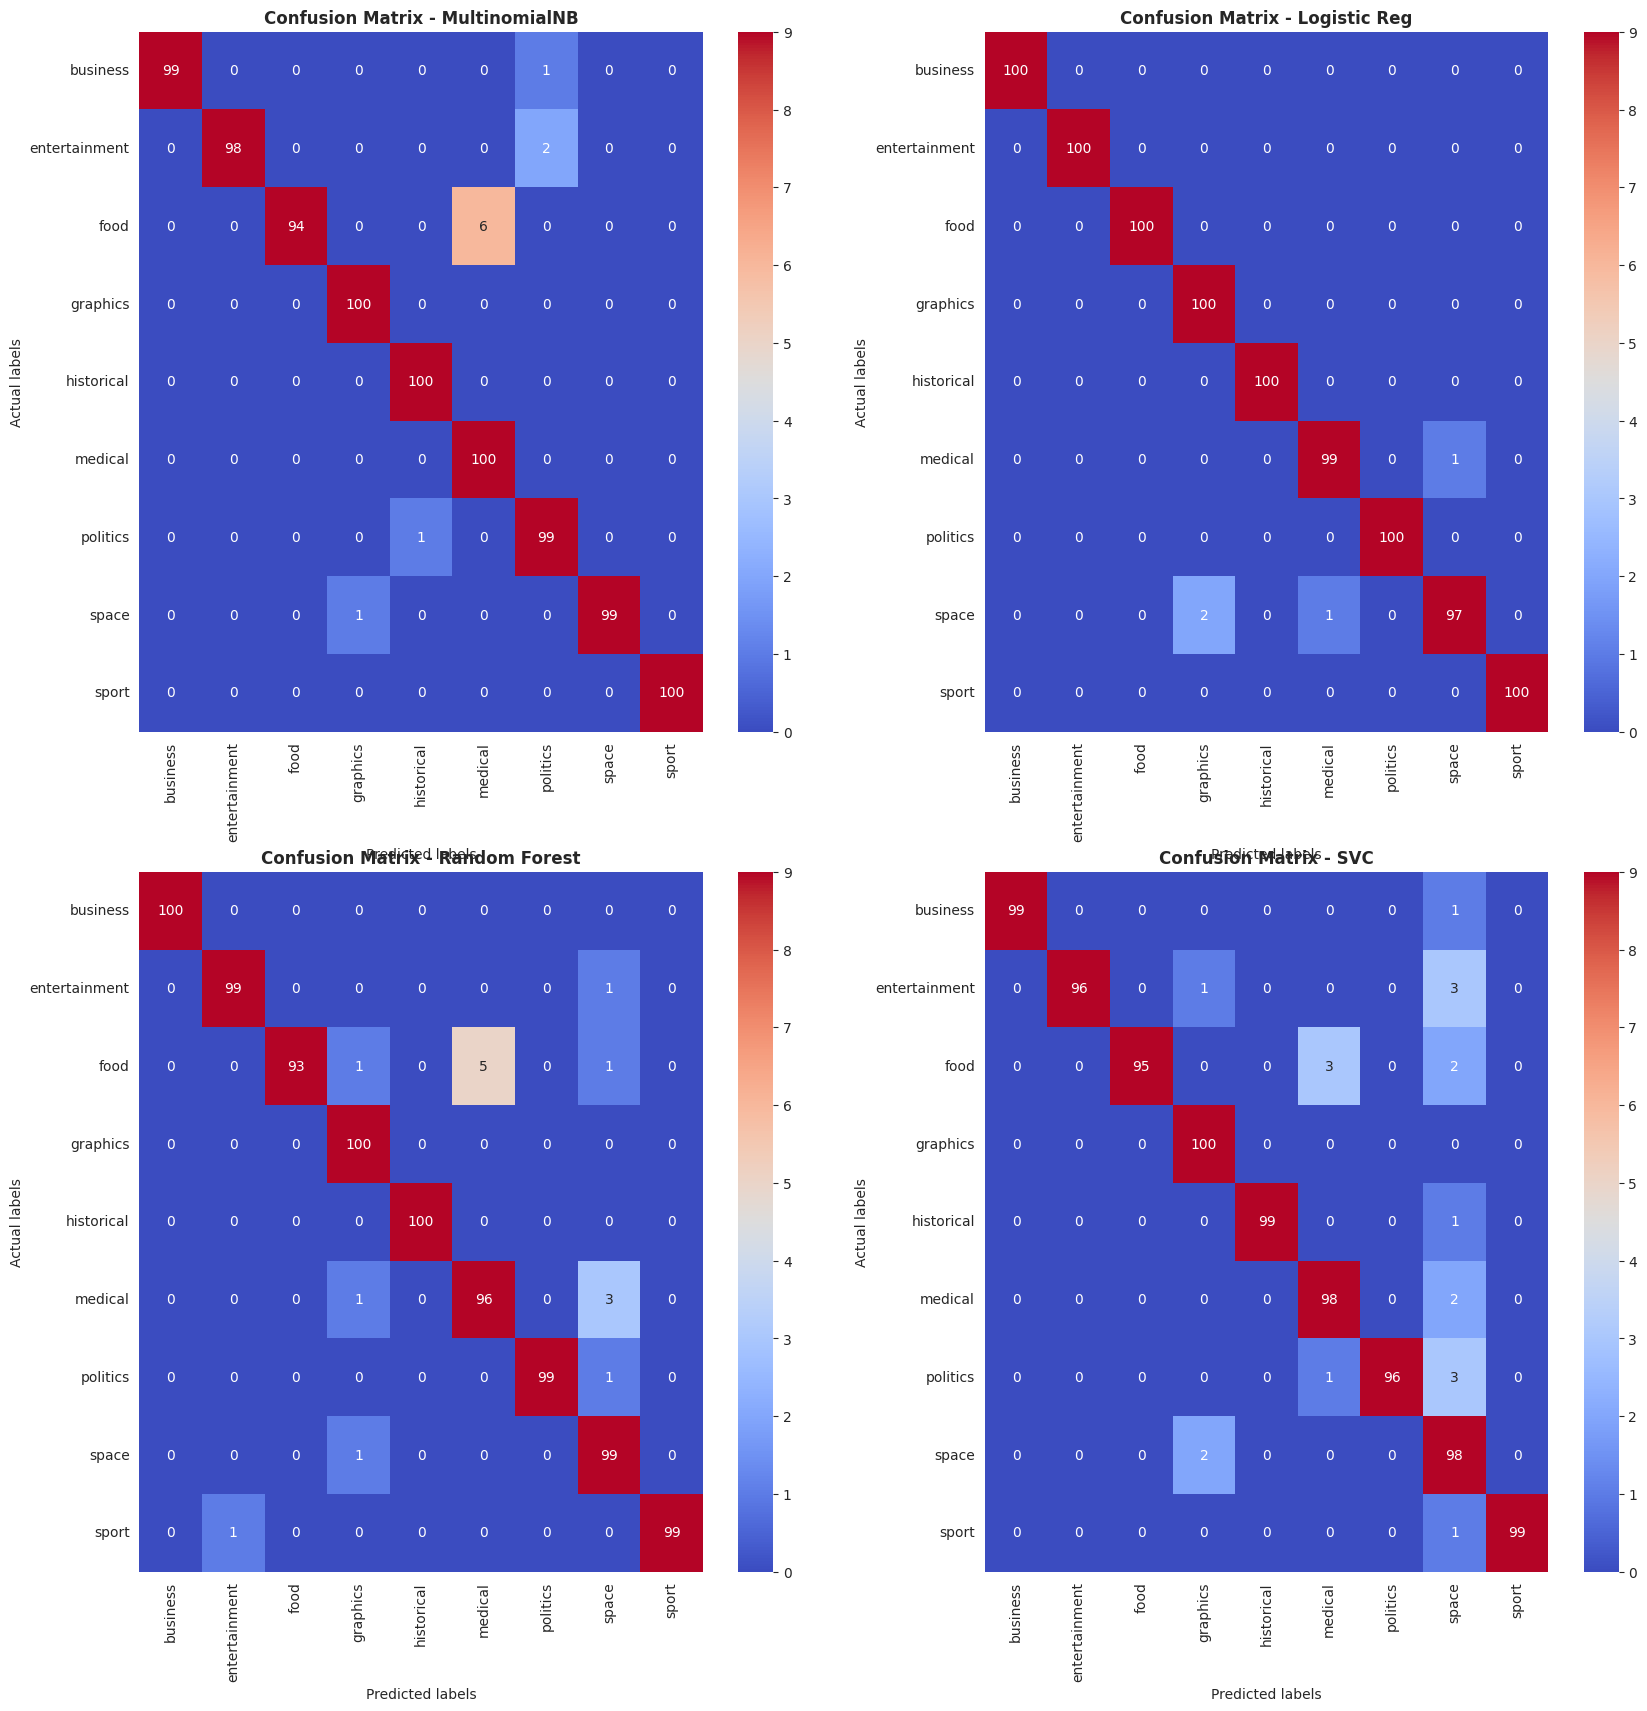

In [13]:
#Plotting confusion matrix for the different models for the Training Data
plt.figure(figsize =(20,20));
plt.subplot(2,2,1); ## Row - Column - Order
pvt_tbl = pd.crosstab(Doc_df["Actual_Label"], Doc_df["Predicted_Label_MultinomialNB()"])
plt.title("Confusion Matrix - MultinomialNB",fontsize=12, weight="bold")
sns.heatmap(pvt_tbl,cmap='coolwarm',annot=True,fmt='.5g',vmin=0, vmax=9);
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')


plt.subplot(2,2,2); ## Row - Column - Order
plt.title("Confusion Matrix - Logistic Reg",fontsize=12, weight="bold")
pvt_tbl = pd.crosstab(Doc_df["Actual_Label"], Doc_df["Predicted_Label_LogisticRegression()"])
sns.heatmap(pvt_tbl,cmap='coolwarm',annot=True,fmt='.5g',vmin=0, vmax=9);
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')


plt.subplot(2,2,3); ## Row - Column - Order
plt.title("Confusion Matrix - Random Forest",fontsize=12, weight="bold")
pvt_tbl = pd.crosstab(Doc_df["Actual_Label"], Doc_df["Predicted_Label_RandomForestClassifier()"])
sns.heatmap(pvt_tbl,cmap='coolwarm',annot=True,fmt='.5g',vmin=0, vmax=9);
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')

plt.subplot(2,2,4); ## Row - Column - Order
plt.title("Confusion Matrix - SVC",fontsize=12, weight="bold")
pvt_tbl = pd.crosstab(Doc_df["Actual_Label"], Doc_df["Predicted_Label_SVC()"])
sns.heatmap(pvt_tbl,cmap='coolwarm',annot=True,fmt='.5g',vmin=0, vmax=9);
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels');

In [14]:
#Intialise Dataframes
model_performance_bow  = pd.DataFrame(columns=["Model","Accuracy","Recall","Precision","Best Params"])
Doc_df_bow  = pd.DataFrame({'Document': documents,'Actual_Label': labels})
# Enhance the loop to use updated doc_clf_model
for model, param_grid in param_grids.items():
    clf, accuracy, recall, precision, best_params = doc_clf_model(model, param_grid, X_bow, labels)
    temp_df_bow = pd.DataFrame({"Model": clf.__class__.__name__,"Accuracy": accuracy,"Recall": recall,"Precision": precision,
                            "Best Params": best_params})
    model_performance_bow = pd.concat([model_performance_bow,temp_df_bow], ignore_index=True)
    Doc_df_bow[f'Predicted_Label_{model}'] = clf.predict(X_bow)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [15]:
model_performance_bow.round(3)

,Model,Accuracy,Recall,Precision,Best Params
0,MultinomialNB,0.963,0.963,0.964,0.01
1,LogisticRegression,0.985,0.985,0.985,sag
2,RandomForestClassifier,0.963,0.963,0.965,1000
3,SVC,0.952,0.952,0.956,linear


In [16]:
Doc_df_bow.head()

,Document,Actual_Label,Predicted_Label_MultinomialNB(),Predicted_Label_LogisticRegression(),Predicted_Label_RandomForestClassifier(),Predicted_Label_SVC()
0,German bidder in talks with LSE\n\nDeutsche Bo...,business,business,business,business,business
1,Cash gives way to flexible friend\n\nSpending ...,business,business,business,business,business
2,McDonald's boss Bell dies aged 44\n\nCharlie B...,business,business,business,business,business
3,"German economy rebounds\n\nGermany's economy, ...",business,business,business,business,business
4,M&S cuts prices by average of 24%\n\nMarks & S...,business,business,business,business,business


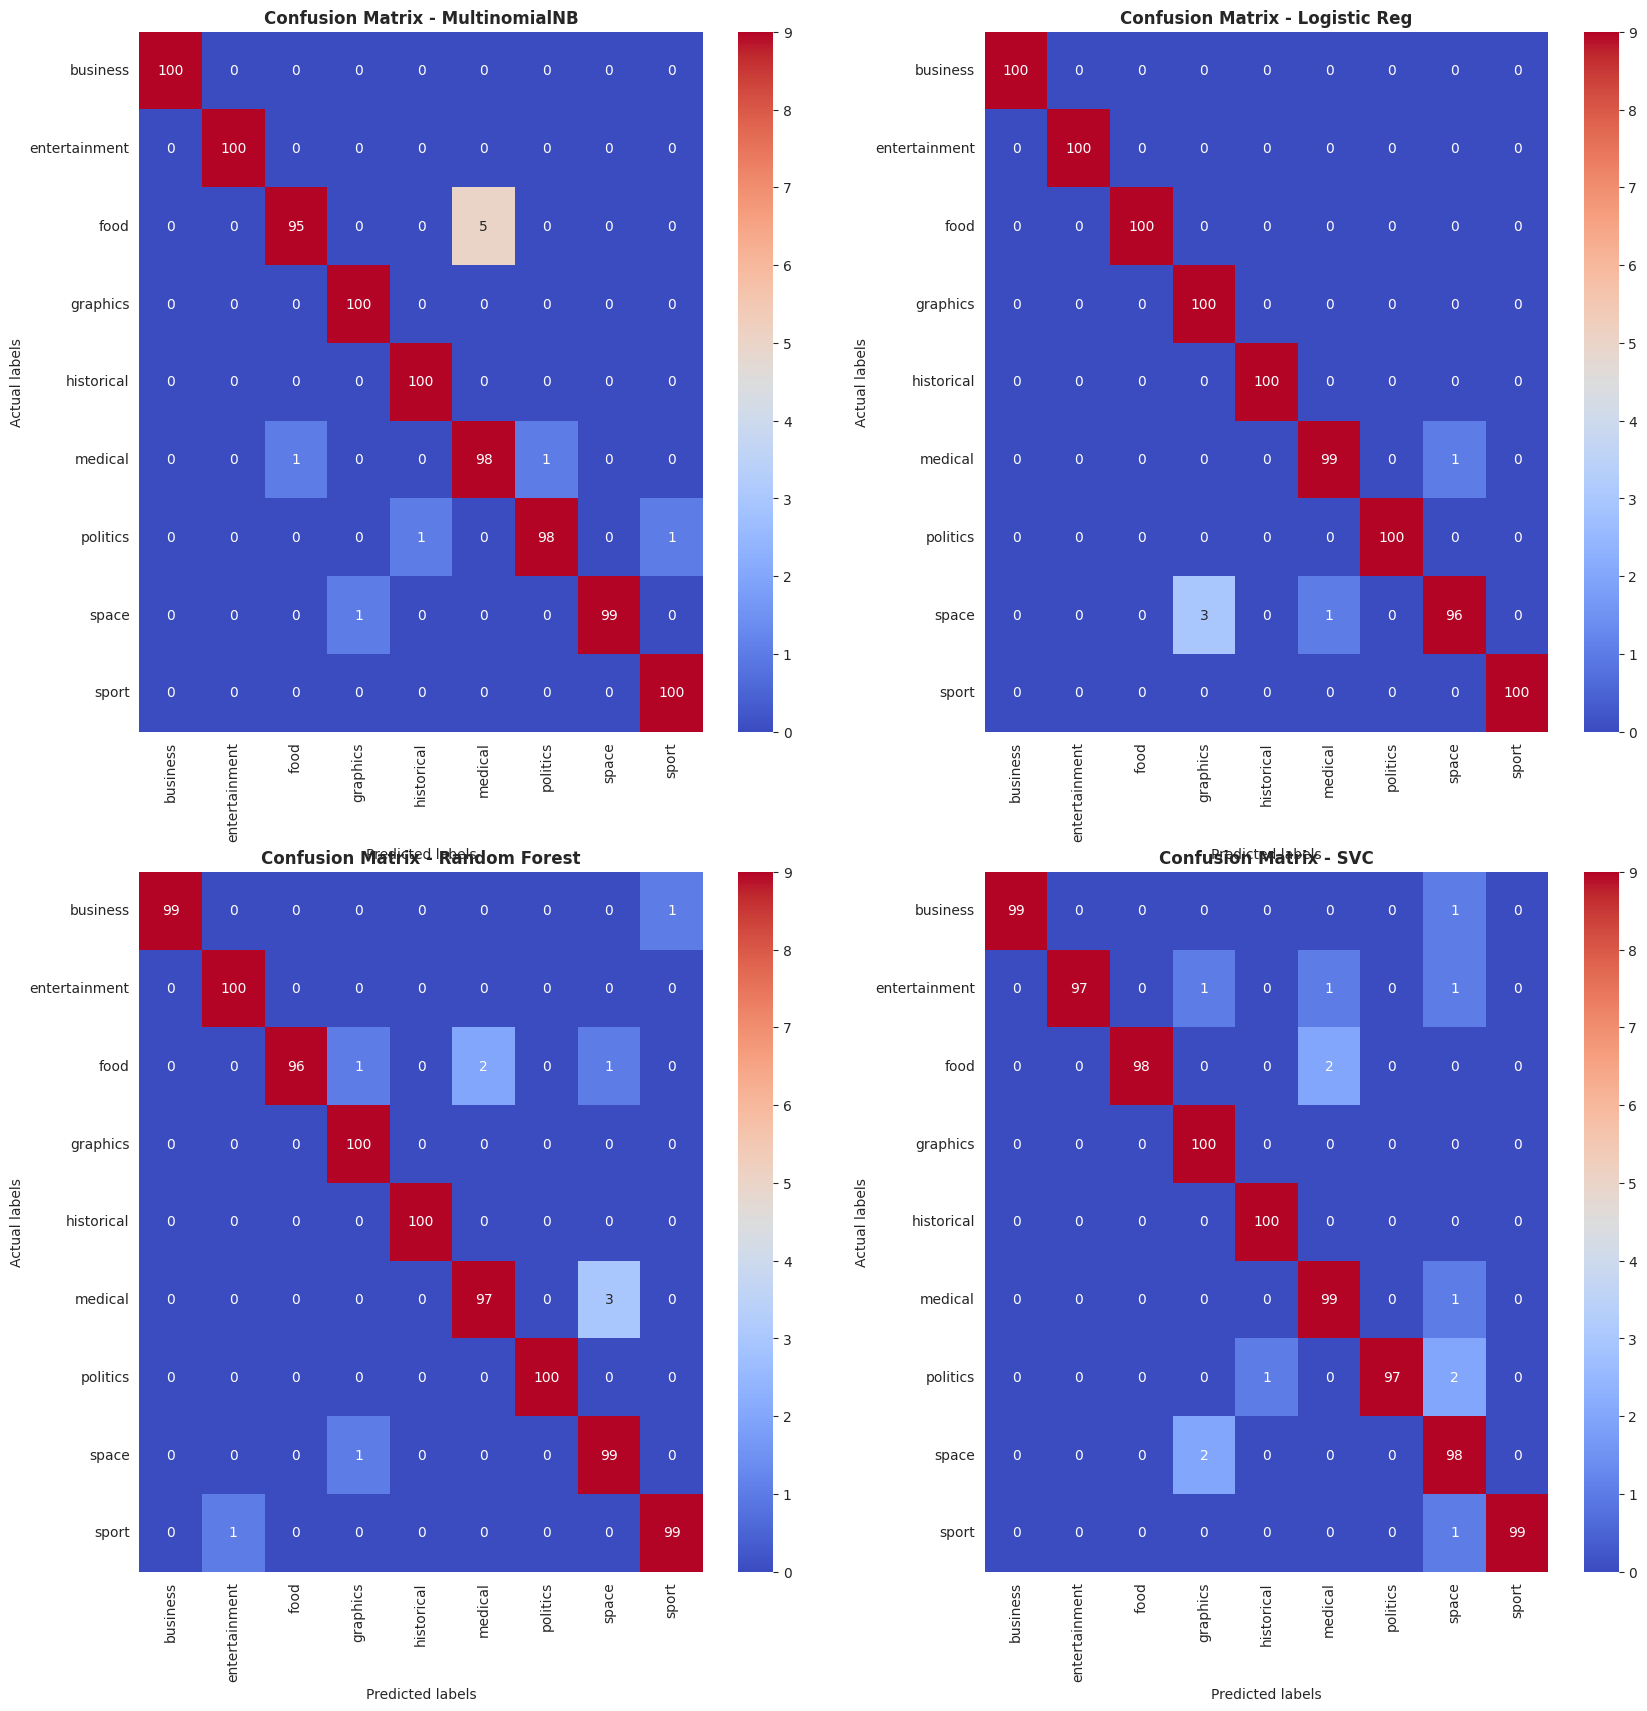

In [17]:
#Plotting confusion matrix for the different models for the Training Data
plt.figure(figsize =(20,20));
plt.subplot(2,2,1); ## Row - Column - Order
pvt_tbl = pd.crosstab(Doc_df_bow["Actual_Label"], Doc_df_bow["Predicted_Label_MultinomialNB()"])
plt.title("Confusion Matrix - MultinomialNB",fontsize=12, weight="bold")
sns.heatmap(pvt_tbl,cmap='coolwarm',annot=True,fmt='.5g',vmin=0, vmax=9);
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')


plt.subplot(2,2,2); ## Row - Column - Order
plt.title("Confusion Matrix - Logistic Reg",fontsize=12, weight="bold")
pvt_tbl = pd.crosstab(Doc_df_bow["Actual_Label"], Doc_df_bow["Predicted_Label_LogisticRegression()"])
sns.heatmap(pvt_tbl,cmap='coolwarm',annot=True,fmt='.5g',vmin=0, vmax=9);
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')


plt.subplot(2,2,3); ## Row - Column - Order
plt.title("Confusion Matrix - Random Forest",fontsize=12, weight="bold")
pvt_tbl = pd.crosstab(Doc_df_bow["Actual_Label"], Doc_df_bow["Predicted_Label_RandomForestClassifier()"])
sns.heatmap(pvt_tbl,cmap='coolwarm',annot=True,fmt='.5g',vmin=0, vmax=9);
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')


plt.subplot(2,2,4); ## Row - Column - Order
plt.title("Confusion Matrix - SVC",fontsize=12, weight="bold")
pvt_tbl = pd.crosstab(Doc_df_bow["Actual_Label"], Doc_df_bow["Predicted_Label_SVC()"])
sns.heatmap(pvt_tbl,cmap='coolwarm',annot=True,fmt='.5g',vmin=0, vmax=9);
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels');